# US college admissions dataset: Improved cutoff estimation and multiple years

In [1]:
using OneTest
using Random

using Plots, Plots.PlotMeasures
using DataFrames
ENV["COLUMNS"] = 20000

using CSV
using Statistics, StatsBase

┌ Info: Precompiling OneTest [1ef6a4a2-16d2-490f-ac5f-8848ea0bfd49]
└ @ Base loading.jl:1342


In [2]:
usadmit = CSV.File("./SchoolIncentives/demand_cutoff.csv") |> DataFrame;
usadmit[1:10, :]

,id,2011demand,2011yield,2011cutoff,2011trueyield,2012demand,2012yield,2012cutoff,2012trueyield,2013demand,2013yield,2013cutoff,2013trueyield,2014demand,2014yield,2014cutoff,2014trueyield,2015demand,2015yield,2015cutoff,2015trueyield,2016demand,2016yield,2016cutoff,2016trueyield,2017demand,2017yield,2017cutoff,2017trueyield,2018demand,2018yield,2018cutoff,2018trueyield,2019demand,2019yield,2019cutoff,2019trueyield,INSTNM
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String
1,100654,872.0,0.243236,0.0,0.000539976,1033.0,0.174641,0.0,0.000646836,1104.0,0.199964,0.0,0.000698344,1207.0,0.231937,0.0,0.000758745,1461.0,0.282811,0.0,0.000906478,1568.0,0.254794,0.00161798,0.000973253,1294.0,0.166495,0.0,0.000791233,1529.0,0.176539,0.00437965,0.000928572,1710.0,0.194561,0.000441295,0.00104098,Alabama A & M University
2,100663,1605.0,0.39856,0.419958,0.00171346,1605.0,0.39856,0.419027,0.00172987,1773.0,0.359343,0.495225,0.00222183,1748.0,0.357245,0.42552,0.00191273,1621.0,0.349655,0.476804,0.00192232,2021.0,0.367521,0.498032,0.00249498,2299.0,0.331459,0.523956,0.00295299,2299.0,0.318157,0.517674,0.00288204,2346.0,0.383835,0.558465,0.00323309,University of Alabama at Birmingham
3,100706,677.0,0.54465,0.557053,0.000946443,624.0,0.414618,0.542295,0.000853676,651.0,0.393116,0.588349,0.00100035,724.0,0.419467,0.653101,0.00131197,1038.0,0.386448,0.684863,0.00204364,1213.0,0.34987,0.693114,0.0024494,1352.0,0.373687,0.730081,0.00306276,1435.0,0.390582,0.741696,0.00335909,1497.0,0.342406,0.744194,0.00356095,University of Alabama in Huntsville
4,100724,1101.0,0.302805,0.0,0.000681782,1106.0,0.316452,0.0,0.000692547,1479.0,0.281661,0.0,0.000935554,1091.0,0.266944,0.0,0.000685825,1021.0,0.263416,0.0,0.00063348,1172.0,0.28207,0.0,0.00072628,967.0,0.144415,0.00827352,0.000596217,1038.0,0.136453,0.00481675,0.000630661,1023.0,0.158188,0.000479544,0.000622785,Alabama State University
5,100751,5766.0,0.598381,0.516113,0.00737885,6397.0,0.456309,0.538494,0.00867947,6454.0,0.368484,0.549454,0.00906129,6824.0,0.39626,0.576267,0.0101236,7211.0,0.371701,0.549368,0.00992843,7559.0,0.375939,0.578728,0.0111193,7407.0,0.3645,0.611352,0.0116535,6663.0,0.302424,0.589508,0.00981447,6764.0,0.212471,0.603641,0.0103841,The University of Alabama
6,100830,813.0,0.475717,0.0418857,0.00052545,871.0,0.677294,0.220396,0.000699581,579.0,0.353264,0.0833812,0.000399568,613.0,0.360165,0.109684,0.000432817,620.0,0.315843,0.132359,0.000443362,594.0,0.266966,0.149606,0.000432855,652.0,0.322453,0.143133,0.000465269,757.0,0.137287,0.121469,0.000521004,626.0,0.168461,0.14052,0.000443193,Auburn University at Montgomery
7,100858,4202.0,0.32759,0.605893,0.00660237,3852.0,0.28563,0.636263,0.00663121,3726.0,0.286021,0.64973,0.00672884,4592.0,0.324431,0.641727,0.00805706,4902.0,0.325131,0.656268,0.0088483,4529.0,0.308011,0.651267,0.00804796,4836.0,0.318829,0.651815,0.0084927,4783.0,0.305721,0.671843,0.00881294,4808.0,0.294969,0.681564,0.00918748,Auburn University
8,100937,278.0,0.240901,0.530275,0.000366487,327.0,0.271595,0.510764,0.000418527,356.0,0.287097,0.558852,0.000510466,382.0,0.258283,0.584744,0.000578278,441.0,0.225922,0.545717,0.000602308,328.0,0.182121,0.476539,0.000388299,349.0,0.220467,0.552567,0.000476944,328.0,0.159223,0.512748,0.000407026,332.0,0.182317,0.525879,0.000426092,Birmingham-Southern College
9,101435,256.0,0.292906,0.0893474,0.000174079,276.0,0.248425,0.0743348,0.000186702,261.0,0.282774,0.096891,0.00018281,227.0,0.27056,0.141579,0.000166232,252.0,0.237512,0.0768432,0.000169368,277.0,0.284394,0.124299,0.00019602,294.0,0.25323,0.126478,0.000205799,249.0,0.208543,0.140422,0.000175152,256.0,0.184838,0.119038,0.000176822,Huntingdon College


In [3]:
years = 2011:2019

# Compute preferability parameters each year (fast)
@time for yr in years 
    usadmit[!, string(yr)*"preferability"] = gammainvopt(usadmit[!, string(yr)*"demand"], usadmit[!, string(yr)*"cutoff"])
end

  0.609536 seconds (1.86 M allocations: 104.681 MiB, 9.93% gc time, 96.55% compilation time)


In [ ]:
U = Float64

# Compute selectiveness parameter each year (a little slow)
# Assume cutoff from subsequent year was school's best response
# Hence we can't calculate for first year
@time Threads.@threads for yr in years[2:end]
    @show yr
    m = Market(U.(usadmit[!, string(yr) * "preferability"]), ones(U, size(usadmit)[1]))
    sig, err = sigmainvopt_disequilibrium(m, U.(usadmit[!, string(yr-1) * "cutoff"]), U.(usadmit[!, string(yr) * "cutoff"]), verbose=false)
    usadmit[!, string(yr)*"selectivity"] = sig
    usadmit[!, string(yr)*"selectivityerror"] = err
end

In [ ]:
# Compute averages
for stat in split("demand cutoff preferability yield trueyield")
    usadmit[!, "average"*stat] = mean(usadmit[!, string(yr) * stat] for yr in years)
    usadmit[!, "median"*stat] = reshape(median(Array(usadmit[!, string.(years) .* stat]), dims=2), :)
end

usadmit[!, "averageselectivity"] = mean(usadmit[!, string(yr) * "selectivity"] for yr in years[2:end])
usadmit[!, "medianselectivity"] = reshape(median(Array(usadmit[!, string.(years[2:end]) .* "selectivity"]), dims=2), :)
usadmit[!, "name"] = usadmit[!, "INSTNM"] 

# Reorder columns
select!(usadmit, vcat("name", sort(setdiff(names(usadmit), ["name", "INSTNM"]))))

# Sort by average preferability
sort!(usadmit, "averagepreferability", rev=true);

## Skip here to read in file from disk

In [2]:
# CSV.write("./SchoolIncentives/results2.csv", usadmit) 
usadmit = CSV.File("./SchoolIncentives/results2.csv") |> DataFrame
years = 2011:2019

2011:2019

In [35]:
usadmit[1:5, :]

,name,2011cutoff,2011demand,2011preferability,2011trueyield,2011yield,2012cutoff,2012demand,2012preferability,2012selectivity,2012selectivityerror,2012trueyield,2012yield,2013cutoff,2013demand,2013preferability,2013selectivity,2013selectivityerror,2013trueyield,2013yield,2014cutoff,2014demand,2014preferability,2014selectivity,2014selectivityerror,2014trueyield,2014yield,2015cutoff,2015demand,2015preferability,2015selectivity,2015selectivityerror,2015trueyield,2015yield,2016cutoff,2016demand,2016preferability,2016selectivity,2016selectivityerror,2016trueyield,2016yield,2017cutoff,2017demand,2017preferability,2017selectivity,2017selectivityerror,2017trueyield,2017yield,2018cutoff,2018demand,2018preferability,2018selectivity,2018selectivityerror,2018trueyield,2018yield,2019cutoff,2019demand,2019preferability,2019selectivity,2019selectivityerror,2019trueyield,2019yield,averagecutoff,averagedemand,averagepreferability,averageselectivity,averagetrueyield,averageyield,id,medianselectivity,mediandemand,mediancutoff,medianpreferability,medianyield,mediantrueyield
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,Harvard University,0.947855,1661.0,0.0256947,0.019725,0.759141,0.964064,1664.0,0.0381526,26.85,-2.57157e-6,0.028995,0.836601,0.959757,1659.0,0.0334182,23.875,-2.6655e-5,0.0260767,0.810454,0.969005,1654.0,0.0426263,31.3,8.11688e-6,0.0335453,0.808802,0.954999,1660.0,0.0284563,21.325,-3.01387e-5,0.0228871,0.798077,0.967153,1663.0,0.0386609,29.45,-1.3289e-5,0.0313742,0.788152,0.975279,1687.0,0.0505795,39.55,2.62383e-5,0.0417266,0.828179,0.974351,1653.0,0.0463296,38.05,-6.84844e-6,0.038967,0.8167,0.964319,1649.0,0.032893,27.25,3.95473e-5,0.0281214,0.820806,0.964087,1661.11,0.0374235,29.7063,0.0301576,0.807435,166027,28.35,1660.0,0.964319,0.0381526,0.810454,0.028995
2,University of Chicago,0.949,1411.0,0.0223811,0.0171324,0.3987,0.952872,1527.0,0.0261575,20.275,-1.72322e-5,0.0202887,0.457186,0.962658,1426.0,0.0311266,25.85,3.22712e-5,0.0241556,0.534082,0.968263,1445.0,0.0363259,30.55,1.42085e-5,0.0286213,0.599834,0.959938,1537.0,0.0300433,24.125,2.21422e-5,0.0238038,0.609679,0.968813,1591.0,0.0391126,31.05,-3.43533e-5,0.031614,0.636655,0.967813,1736.0,0.0382324,30.15,5.01871e-5,0.0329793,0.717652,0.971634,1805.0,0.045036,34.45,3.72263e-5,0.0384746,0.769723,0.974197,1726.0,0.0498784,37.9,8.70107e-6,0.0407021,0.807674,0.96391,1578.22,0.035366,29.2938,0.0286413,0.614576,144050,30.35,1537.0,0.967813,0.0363259,0.609679,0.0286213
3,Washington University in St Louis,0.960484,1488.0,0.0310346,0.0233181,0.312408,0.960961,1640.0,0.0344913,24.675,2.49877e-5,0.0263053,0.336341,0.961829,1610.0,0.0343521,25.25,9.23101e-6,0.0266807,0.343723,0.966321,1734.0,0.0408014,28.75,3.89376e-5,0.0323647,0.346523,0.959537,1731.0,0.033468,23.875,2.46293e-5,0.0265429,0.35341,0.955379,1776.0,0.0287117,21.475,-3.41842e-5,0.0246648,0.36793,0.958957,1778.0,0.028662,23.55,9.42028e-6,0.0264891,0.365618,0.967552,1797.0,0.0381467,30.05,3.38913e-5,0.0334859,0.381691,0.959929,1732.0,0.0291645,24.175,6.14153e-6,0.0263012,0.491766,0.961217,1698.44,0.0332036,25.225,0.0273503,0.366601,179867,24.425,1732.0,0.960484,0.033468,0.35341,0.0264891
4,University of Pennsylvania,0.927825,2459.0,0.0253522,0.0210975,0.624905,0.930524,2461.0,0.0257059,13.525,-4.59655e-5,0.0221805,0.625413,0.941443,2421.0,0.0307077,16.225,-2.4598e-5,0.0261527,0.632115,0.944678,2425.0,0.0302703,17.275,3.71823e-5,0.0275552,0.652232,0.948471,2435.0,0.0351658,18.625,1.97

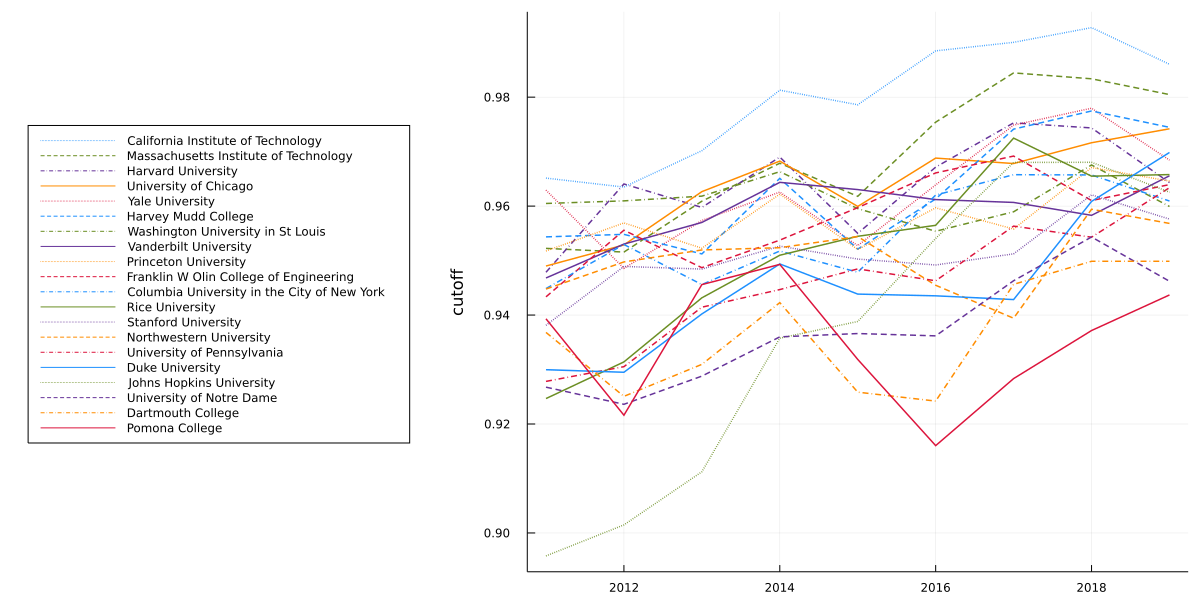

In [3]:
colors = [:crimson, :dodgerblue, :olivedrab, :rebeccapurple, :darkorange]
lines = [:solid, :dot, :dash, :dashdot]

function plot_doer(stat, N=20)
    pl = plot(size=(1200, 600), legend=:outerleft, ylabel=stat)

    let years = (stat == "selectivity" ? years[2:end] : years)
        for (rank, id) in enumerate(partialsortperm(usadmit[!, "average"*stat], 1:N, rev=true))
            plot!(pl,
                  years,
                  [usadmit[id, string(yr) * stat] for yr in years],
                  c=colors[1 + rank % length(colors)],
                  ls=lines[1 + rank % length(lines)],
                  lw=1.5, 
                  label=usadmit[id, "name"])
        end
    end

    return pl
end

pl = plot_doer("cutoff")

# savefig(pl, "paper/singlescoreplots/top-20-cutoff-timeseries.pdf")

pl

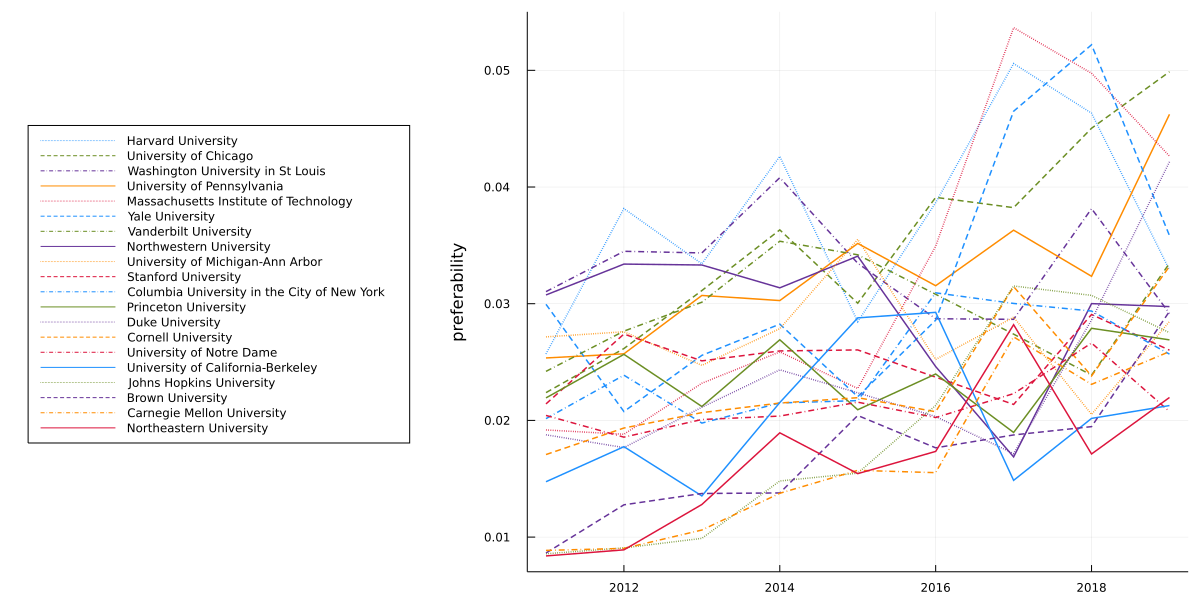

In [4]:
pl = plot_doer("preferability")

# savefig(pl, "paper/singlescoreplots/top-20-gamma-timeseries.pdf")

pl

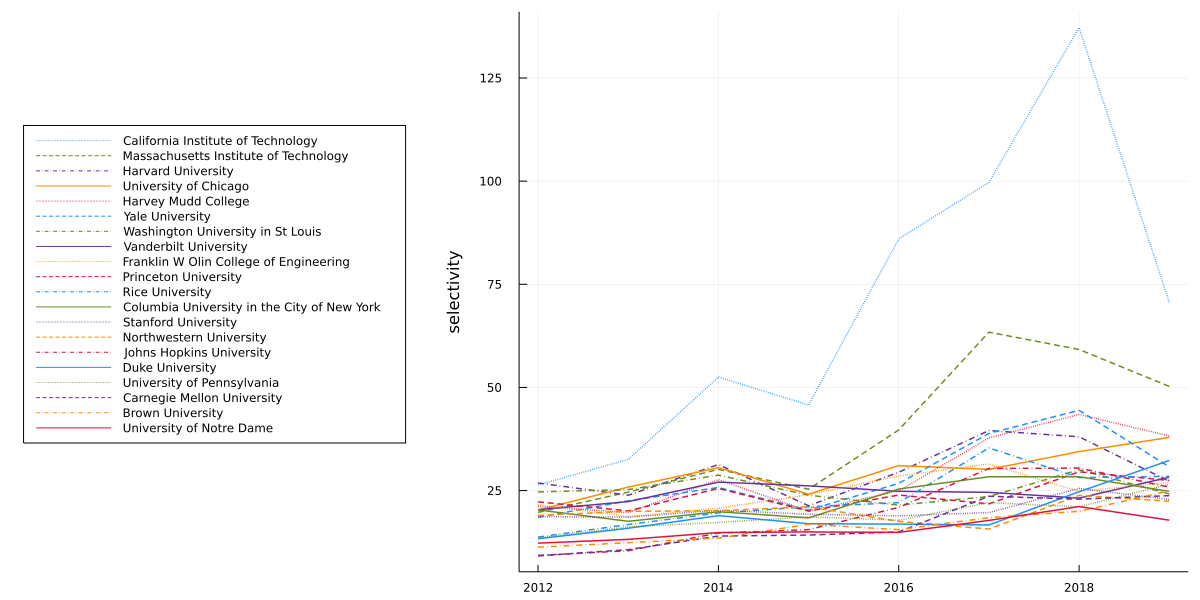

In [5]:
pl = plot_doer("selectivity")

# savefig(pl, "paper/singlescoreplots/top-20-sigma-timeseries.pdf")

pl

In [7]:
cor_cols = vcat([string(yr) * s for s in split("cutoff demand preferability") for yr in years],
                [string(yr) * "selectivity" for yr in years[2:end]])
cor_cols_names = vcat([string(yr) * " " * s for s in split("cutoff demand preferability") for yr in years],
                      [string(yr) * " " * "selectivity" for yr in years[2:end]])
                
cor_mat = cor(Matrix(usadmit[:, cor_cols]))

pl = heatmap(cor_mat[end:-1:begin, :],
             size=(960, 900),
             leftmargin=120px,
             topmargin=100px,
             color=palette(:viridis),
             colorbar_title="covariance",
             ticks=false, axis=false)

for i in 1:length(cor_cols), j in 1:length(cor_cols)
    c = (cor_mat[i, j] < 0.45 ? :white : :black)
    annotate!(pl, [(i, 1 + length(cor_cols) - j, text(round(cor_mat[i, j], digits=2), font(5, :hmiddle, :vmiddle, c)))])
end

for (x, s) in enumerate(cor_cols_names)
    annotate!(pl, [(x, length(cor_cols) + 0.6, text(s, font(8, rotation=45, :left, :bottom)))])
    annotate!(pl, [(0.2, 1 + length(cor_cols) - x, text(s, font(8, rotation=0, :right, :vmiddle)))])
end

# savefig(pl, "paper/singlescoreplots/cutoff-demand-gamma-sigma-corr-heatmap.pdf")

# pl

In [62]:
function plot_doer_rand(stat, N=20)
    pl = plot(size=(1200, 600), legend=:outerleft, ylabel=stat)

    let years = (stat == "selectivity" ? years[2:end] : years)
        for (rank, id) in enumerate(partialsortperm(usadmit[!, "average"*stat], rand(1:size(usadmit)[1]-N) .+ (1:N), rev=true))
            plot!(pl,
                  years,
                  [usadmit[id, string(yr) * stat] for yr in years],
                  c=colors[1 + rank % length(colors)],
                  ls=lines[1 + rank % length(lines)],
                  lw=1.5, 
                  label=usadmit[id, "name"])
        end
    end

    return pl
end

plot_doer_rand (generic function with 2 methods)

In [8]:
function year_pairplot(plot_years, stat)
    pl = plot(layout=(length(plot_years), length(plot_years)), size=(820, 800), legend=false, ticks=false,
              margin=-1mm)

    colors = palette(:Dark2_8)

    for (i, x) in enumerate(plot_years), (j, y) in enumerate(plot_years)

        if i==j
            histogram!(pl[i, j], log.(usadmit[!, "$(x)$(stat)"]),
                       lc=nothing, c=:steelblue)
        else
            scatter!(pl[i, j], ms=1.2, ma=0.2, msw=0.0, c=colors[abs(i-j)],
                     log.(usadmit[!, "$(x)$(stat)"]),
                     log.(usadmit[!, "$(y)$(stat)"]))
        end

        if y == plot_years[1]
            plot!(pl[i, j], ylabel=x, yguidefontsize=9, leftmargin=7mm)
        end

        if x == plot_years[end]
            plot!(pl[i, j], xlabel=y, xguidefontsize=9, bottommargin=5mm)
        end
    end
    return pl
end

pl = year_pairplot(2011:2019, "preferability")

# savefig(pl, "paper/singlescoreplots/preferability-pairplot.pdf")

# pl

In [10]:
pl = year_pairplot(2012:2019, "selectivity")

# savefig(pl, "paper/singlescoreplots/selectivity-pairplot.pdf")

# pl

In [38]:
using Plots, StatsBase
n = 10^6
f(x) = n * x * log(10)
x = rand(n)
b = 10.0 .^ (-5:0.2:0)
h = fit(Histogram{Float64}, x, b)
h.weights ./= diff(log10.(h.edges[1]))
plot(h; alpha=0.3, label="", xscale=:log10, xlim=extrema(b))

(mean(x), std(x)) = (0.0009319664492078298, 0.003900205228279921)


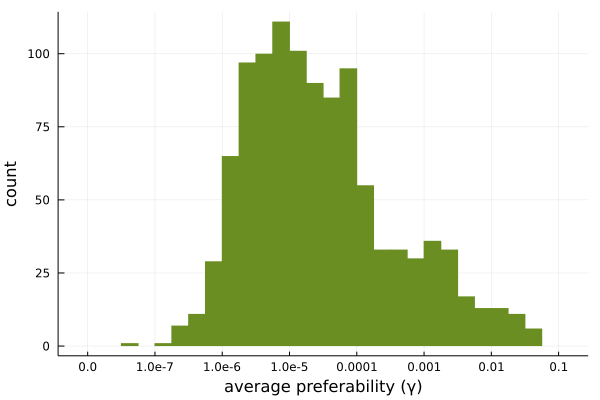

In [81]:
x = usadmit[!, "averagepreferability"]
@show mean(x), std(x)
b = 10.0 .^ vcat(-Inf, -7.75:0.25:-1)
h = fit(Histogram, x, b)

pl = bar(1:length(b), h.weights, bar_width=1.05, lc=nothing, xticks=(1:4:length(b), b[1:4:length(b)]),
         label="", xlabel="average preferability (γ)", ylabel="count", c=:olivedrab)

# savefig(pl, "paper/singlescoreplots/average-preferability-hist.pdf")

pl

sum(x .== 0) = 9
(mean(x[x .> 0]), std(x[x .> 0])) = (1.4818985329534775, 4.1591227814903995)


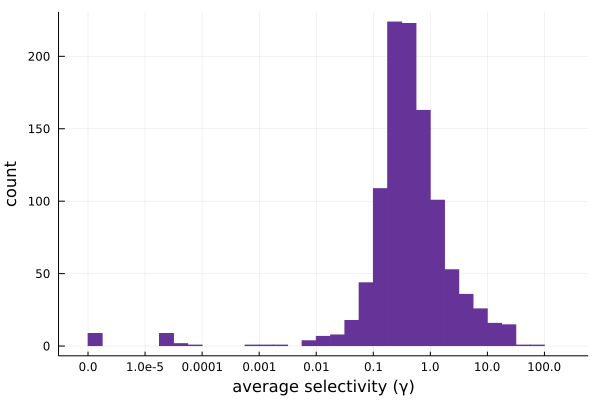

In [84]:
x = usadmit[!, "averageselectivity"]
@show sum(x .== 0)
@show mean(x[x .> 0]), std(x[x .> 0])
b = 10.0 .^ vcat(-Inf, -5.75:0.25:2.25)
h = fit(Histogram, x, b)

pl = bar(1:length(b), h.weights, bar_width=1.05, lc=nothing, xticks=(1:4:length(b), b[1:4:length(b)]),
         label="", xlabel="average selectivity (γ)", ylabel="count", c=:rebeccapurple)

# savefig(pl, "paper/singlescoreplots/average-selectivity-hist.pdf")

pl

## Updated versions of plots from previous analysis

Want to find analogues of Caltech, Whitman, and U Vermont demand curves.

1. Harvard University
2. University of Chicago
3. Washington University in St Louis
4. University of Pennsylvania
5. Massachusetts Institute of Technology
6. Yale University
7. Vanderbilt University
8. Northwestern University
9. University of Michigan-Ann Arbor
10. Stanford University
11. Columbia University in the City of New York
12. Princeton University
13. Duke University
14. Cornell University
15. University of Notre Dame
16. University of California-Berkeley
17. Johns Hopkins University
18. Brown University
19. Carnegie Mellon University
20. Northeastern University

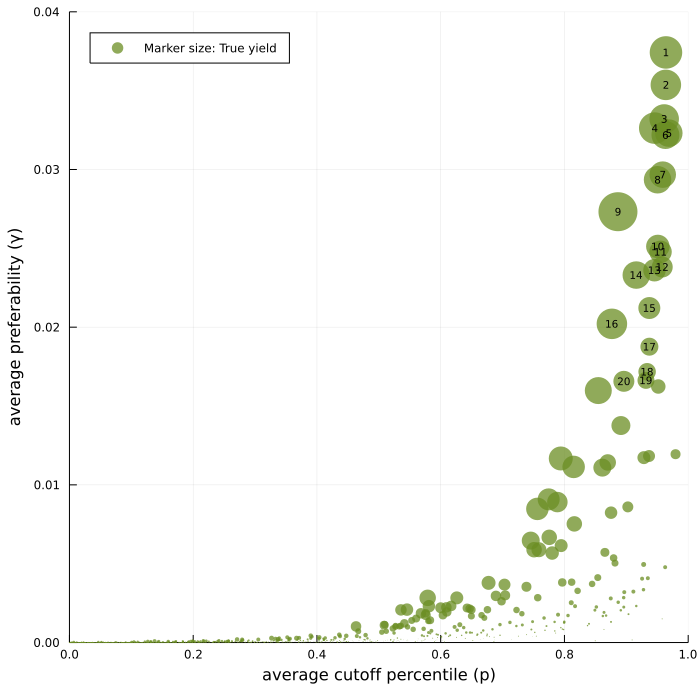

In [78]:
function plot_cutoff_gamma(stats::DataFrame)

    pl = plot(size=(700, 700), xlim=(0, 1), ylim=(0, 0.04),#1.1*maximum(stats[!, :preferability])),
              xlabel="average cutoff percentile (p)", ylabel="average preferability (γ)", legend=:topleft,
#               title="Admissions standards, class size and school preferability",
              titlefontsize=12)

    scatter!(pl,
             stats[!, :averagecutoff],
             stats[!, :averagepreferability],
             marker=:circle,
             ms=600*stats[!, :averagetrueyield],
             msw=0, msa=0,
             ma=.75,
             color=:olivedrab,
             label="Marker size: True yield")

    numsfont = text("").font
    numsfont.rotation = 0
    numsfont.halign = :hcenter
    numsfont.valign = :vcenter
    numsfont.pointsize = 7

    best = sortperm(stats[!, :averagepreferability], rev=true)

    n = 20

    for i in 1:n
        annotate!(pl,
              [(stats[best[i], :averagecutoff], 
                stats[best[i], :averagepreferability],
                text(i, numsfont))])
    end

    font = text("").font
    font.rotation = 0
    font.halign = :left
    font.valign = :top
    font.pointsize = 9

    key = join([string(i)*". "*stats[best[i], :name] for i in 1:n], '\n')
    # annotate!(pl, [(0.07, 0.043, text(key, font))])
    print(key)

    return pl
end

pl = plot_cutoff_gamma(usadmit)

# savefig(pl, "paper/singlescoreplots/US-cutoff-gamma.pdf")

pl

In [37]:
# Top 20 table. Later on we will want to add yield and true yield. 
best = sortperm(usadmit[!, :averagepreferability], rev=true)
top20 = usadmit[best[1:20], split("name averagedemand averagecutoff averageyield averagetrueyield averagepreferability averageselectivity")]
top20[!, "name"] = replace.(top20[:, "name"], Pair("University", "U"))
top20[!, "averagedemand"] = round.(Int, top20[:, "averagedemand"])
top20[!, "averagecutoff"] = round.(top20[:, "averagecutoff"], digits=4)
top20[!, "averageyield"] = round.(top20[:, "averageyield"], digits=4)
top20[!, "averagetrueyield"] = round.(top20[:, "averagetrueyield"], digits=4)
top20[!, "averagepreferability"] = round.(top20[:, "averagepreferability"], digits=4)
top20[!, "averageselectivity"] = round.(top20[:, "averageselectivity"], digits=2)
top20

,name,averagedemand,averagecutoff,averageyield,averagetrueyield,averagepreferability,averageselectivity
,String,Int64,Float64,Float64,Float64,Float64,Float64
1,Harvard U,1661,0.9641,0.8074,0.0302,0.0374,29.71
2,U of Chicago,1578,0.9639,0.6146,0.0286,0.0354,29.29
3,Washington U in St Louis,1698,0.9612,0.3666,0.0274,0.0332,25.22
4,U of Pennsylvania,2452,0.9459,0.6532,0.0292,0.0326,19.15
5,Massachusetts Institute of Technology,1105,0.9687,0.7265,0.0257,0.0323,39.05
6,Yale U,1427,0.9633,0.6784,0.0261,0.0322,28.48
7,Vanderbilt U,1605,0.9589,0.4375,0.0246,0.0297,24.59
8,Northwestern U,2017,0.9505,0.4738,0.0256,0.0293,19.95
9,U of Michigan-Ann Arbor,6475,0.8865,0.4222,0.0362,0.0273,8.41


In [42]:
usadmit[24, :]

,name,2011cutoff,2011demand,2011preferability,2011selectivity,2011selectivityerror,2011trueyield,2011yield,2012cutoff,2012demand,2012preferability,2012selectivity,2012selectivityerror,2012trueyield,2012yield,2013cutoff,2013demand,2013preferability,2013selectivity,2013selectivityerror,2013trueyield,2013yield,2014cutoff,2014demand,2014preferability,2014selectivity,2014selectivityerror,2014trueyield,2014yield,2015cutoff,2015demand,2015preferability,2015selectivity,2015selectivityerror,2015trueyield,2015yield,2016cutoff,2016demand,2016preferability,2016selectivity,2016selectivityerror,2016trueyield,2016yield,2017cutoff,2017demand,2017preferability,2017selectivity,2017selectivityerror,2017trueyield,2017yield,2018cutoff,2018demand,2018preferability,2018selectivity,2018selectivityerror,2018trueyield,2018yield,2019cutoff,2019demand,2019preferability,2019trueyield,2019yield,averagecutoff,averagedemand,averagepreferability,averageselectivity,averagetrueyield,averageyield,id
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
24,California Institute of Technology,0.965142,244.0,0.00578404,26.35,-5.42487e-5,0.00433454,0.365817,0.963491,244.0,0.00550322,32.55,2.36144e-5,0.00418491,0.365817,0.97017,249.0,0.00681336,52.5,2.48397e-5,0.00528018,0.42637,0.981284,226.0,0.00968274,45.75,9.5341e-6,0.00759056,0.392361,0.9786,241.0,0.00889073,86.0,8.37321e-6,0.00698734,0.420593,0.988497,235.0,0.0159474,99.7,6.42585e-6,0.0126604,0.424955,0.990063,235.0,0.0181048,137.2,6.89512e-6,0.0144606,0.413732,0.992757,231.0,0.0240131,70.6,1.51795e-6,0.0192845,0.425414,0.986032,235.0,0.0127603,0.0102374,0.437616,0.97956,237.778,0.0119444,68.8313,0.00944671,0.408075,110404


## Demand curves

We will base these on the year `base_year` for no reason.

In [21]:
U = Float64
base_year = "2015"
america = Market(log.(convert(Array{U}, usadmit[!, base_year * "preferability"])),
                       ones(U, size(usadmit)[1]))

Market{Float64}([-3.5593855162455483, -3.505115166103383, -3.3971644531752303, -3.3476825557066197, -3.783660471325069, -3.8151425662839418, -3.375779576456498, -3.379155433766668, -3.3379462843188485, -3.6481706441532493  …  -15.450274835936485, -15.005794006745145, -15.581295093305759, -15.704740734305458, -15.72861902993735, -15.42125467185222, -16.82380156163394, -16.027262161490835, -15.941355552704808, -16.12420714603692], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.028456305280178944, 0.03004331317361886, 0.03346803572287719, 0.035165754420966276, 0.022739302332373087, 0.022034572842537903, 0.03419145306739337, 0.03407622221150893, 0.03550980994063008, 0.026038719318894857  …  1.9499833128414508e-7, 3.0413504514019146e-7, 1.7105253706953964e-7, 1.511881522652095e-7, 1.4762079754387975e-7, 2.0074012580551125e-7, 4.93759900819289e-8, 1.0950866466158908e-7, 1.1933209066321246e-7, 9.939071421210683e-8])

In [68]:
# Should agree
hcat(sum(usadmit[!, base_year * "demand"]) * demand(america, usadmit[!, base_year * "cutoff"]), usadmit[!, base_year * "demand"])

1073×2 Matrix{Float64}:
 1660.0  1660.0
 1537.0  1537.0
 1731.0  1731.0
 2435.0  2435.0
 1106.0  1106.0
 1364.0  1364.0
 1607.0  1607.0
 2018.0  2018.0
 6092.0  6092.0
 1720.0  1720.0
 1527.0  1527.0
 1319.0  1319.0
 1746.0  1746.0
    ⋮    
   98.0    98.0
  112.0   112.0
   25.0    25.0
   13.0    13.0
   97.0    97.0
   22.0    22.0
   24.0    24.0
   16.0    16.0
   28.0    28.0
   55.0    55.0
   11.0    11.0
    3.0     3.0

In [43]:
idxs_to_plot = [50, best[156:157]...]
single_out = idxs_to_plot[1]

function calc_demand_curves(ran, idxs_to_plot)
    fixed_cuts = copy(usadmit[!, base_year * "cutoff"])
    cuts_to_plot = vcat(ran, usadmit[idxs_to_plot, base_year * "cutoff"]) |> sort
    
    total_demand = sum(usadmit[!, base_year * "demand"])
    
    res = zeros(length(cuts_to_plot), length(idxs_to_plot))
    
    for (c, i) in enumerate(idxs_to_plot)
        p = copy(fixed_cuts)
        for (d, t) in enumerate(cuts_to_plot)
            p[i] = t
            res[d, c] = demand(america, p)[i] * total_demand
        end
    end
    
    return cuts_to_plot, res
end


function plot_demand_curves(cuts, curves)
    pl = plot(xlabel="cutoff (p)", ylabel="demand (number of students)",
              size=(700, 500), yticks=([0, 5000, 10000, 15000, 20000], [0, 5000, 10000, 15000, 20000]))
    
    colors = [:crimson, :dodgerblue, :olivedrab, :rebeccapurple]
    
    for (c, i) in enumerate(idxs_to_plot)
        plot!(pl,
              cuts, 
              curves[:, c],
              label=usadmit[i, :name],
              color = colors[c])
        
        vline!(pl,
               [usadmit[i, base_year * "cutoff"]],
               color = colors[c], ls=:dash, label=nothing)
    end
    
    plot!(pl, [0.75], [1], ms=nothing,
           color = :black, ls=:dash, label="Current cutoffs", legend=true)
    
    return pl
end

plot_demand_curves (generic function with 1 method)

In [46]:
usadmit[idxs_to_plot, :]

,name,2011cutoff,2011demand,2011preferability,2011selectivity,2011selectivityerror,2011trueyield,2011yield,2012cutoff,2012demand,2012preferability,2012selectivity,2012selectivityerror,2012trueyield,2012yield,2013cutoff,2013demand,2013preferability,2013selectivity,2013selectivityerror,2013trueyield,2013yield,2014cutoff,2014demand,2014preferability,2014selectivity,2014selectivityerror,2014trueyield,2014yield,2015cutoff,2015demand,2015preferability,2015selectivity,2015selectivityerror,2015trueyield,2015yield,2016cutoff,2016demand,2016preferability,2016selectivity,2016selectivityerror,2016trueyield,2016yield,2017cutoff,2017demand,2017preferability,2017selectivity,2017selectivityerror,2017trueyield,2017yield,2018cutoff,2018demand,2018preferability,2018selectivity,2018selectivityerror,2018trueyield,2018yield,2019cutoff,2019demand,2019preferability,2019trueyield,2019yield,averagecutoff,averagedemand,averagepreferability,averageselectivity,averagetrueyield,averageyield,id
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,Amherst College,0.923196,461.0,0.00436865,12.175,7.74368e-6,0.00371684,0.409051,0.923105,461.0,0.00421088,13.575,7.06705e-5,0.00375402,0.409051,0.930738,466.0,0.00469455,14.425,0.000104944,0.0042559,0.411661,0.934351,469.0,0.00457394,16.275,5.3797e-5,0.00449092,0.399829,0.941388,477.0,0.00574211,13.525,-8.68909e-5,0.00504941,0.394215,0.930333,471.0,0.00408943,18.675,-2.09138e-5,0.00418959,0.409922,0.948732,471.0,0.00549822,10.4375,1.20235e-5,0.00561748,0.393155,0.910944,492.0,0.00204203,8.0625,6.42265e-5,0.00334043,0.394864,0.886739,470.0,0.00123075,0.00252505,0.393305,0.925503,470.889,0.00405006,13.3938,0.0041044,0.401672,164465
2,University of Louisville,0.438113,2561.0,0.000703692,1.03906,0.000114484,0.0028224,0.441247,0.473457,2569.0,0.000753626,1.36094,-9.06104e-6,0.00305509,0.447717,0.548871,2857.0,0.00114195,1.37031,7.09259e-5,0.00400599,0.438257,0.550221,2887.0,0.000664548,1.37656,7.16688e-5,0.00403493,0.368616,0.549199,2797.0,0.00071655,1.51094,0.000224275,0.00384959,0.402852,0.578804,2883.0,0.00113328,1.17656,-0.00119593,0.00424167,0.381854,0.516393,2796.0,0.000126348,1.28906,0.000206267,0.00353521,0.337967,0.533443,2932.0,9.68945e-5,1.28906,4.34682e-5,0.0037998,0.292265,0.533149,2803.0,0.000102976,0.00365342,0.274105,0.524628,2787.22,0.000604429,1.30156,0.00366646,0.376098,157289
3,Whitman College,0.8315,399.0,0.00128225,4.51875,-6.60957e-5,0.00146633,0.241233,0.813519,381.0,0.000964448,3.93125,-9.34936e-5,0.00127933,0.274496,0.791514,392.0,0.000770343,4.20625,-0.000119694,0.00118935,0.266124,0.802675,395.0,0.000633257,3.69375,-9.55484e-5,0.00125835,0.263685,0.779334,364.0,0.000504876,3.06562,-0.000115208,0.00102347,0.22483,0.744369,405.0,0.000448426,2.57188,-0.000102114,0.000981788,0.211488,0.709665,389.0,0.000137006,4.14375,-0.00022176,0.000819256,0.184273,0.799746,426.0,0.000333233,4.15625,-0.000148643,0.00128626,0.162533,0.799873,425.0,0.000327211,0.00129222,0.157582,0.785799,397.333,0.000600117,3.78594,0.00117737,0.220694,237057


In [66]:
usadmit[sortperm(usadmit[:, "2015cutoff"])[1040:end], :]

,name,2011cutoff,2011demand,2011preferability,2011selectivity,2011selectivityerror,2011trueyield,2011yield,2012cutoff,2012demand,2012preferability,2012selectivity,2012selectivityerror,2012trueyield,2012yield,2013cutoff,2013demand,2013preferability,2013selectivity,2013selectivityerror,2013trueyield,2013yield,2014cutoff,2014demand,2014preferability,2014selectivity,2014selectivityerror,2014trueyield,2014yield,2015cutoff,2015demand,2015preferability,2015selectivity,2015selectivityerror,2015trueyield,2015yield,2016cutoff,2016demand,2016preferability,2016selectivity,2016selectivityerror,2016trueyield,2016yield,2017cutoff,2017demand,2017preferability,2017selectivity,2017selectivityerror,2017trueyield,2017yield,2018cutoff,2018demand,2018preferability,2018selectivity,2018selectivityerror,2018trueyield,2018yield,2019cutoff,2019demand,2019preferability,2019trueyield,2019yield,averagecutoff,averagedemand,averagepreferability,averageselectivity,averagetrueyield,averageyield,id
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,Georgia Institute of Technology-Main Campus,0.808782,2712.0,0.00715171,5.30625,-7.72827e-5,0.00878253,0.388761,0.837258,2695.0,0.00852798,5.61875,6.69256e-5,0.0103694,0.373786,0.844829,3044.0,0.00974483,9.2625,2.95494e-5,0.012409,0.378372,0.900937,2809.0,0.0146969,9.1375,-1.41732e-5,0.017825,0.325078,0.899427,3089.0,0.016828,9.1875,-0.000113974,0.0190565,0.352023,0.90032,2877.0,0.014804,5.13125,-8.78467e-5,0.0178858,0.365658,0.833325,2861.0,0.00391806,14.125,3.51452e-5,0.0104958,0.388248,0.932676,3146.0,0.0209646,7.0375,3.09273e-5,0.0282545,0.410009,0.872106,3076.0,0.00614955,0.014635,0.405591,0.869962,2923.22,0.0114206,8.10078,0.0155237,0.376392,139755
2,Carleton College,0.902428,519.0,0.00357038,10.0375,-4.77324e-5,0.00329381,0.335705,0.908343,528.0,0.00379338,10.0125,-1.09681e-5,0.00360713,0.352941,0.908051,527.0,0.00356991,9.9875,6.25246e-5,0.00362548,0.357046,0.907649,521.0,0.00303473,9.1875,-2.43078e-5,0.00354639,0.363319,0.899913,491.0,0.00269509,9.1125,-0.000103396,0.00304377,0.353746,0.899583,567.0,0.00288533,14.825,6.10599e-5,0.00349907,0.386503,0.935974,522.0,0.00416472,11.1375,3.3721e-5,0.00498523,0.37881,0.916417,529.0,0.00243627,12.4375,1.27867e-5,0.00382685,0.375977,0.924413,525.0,0.00291371,0.00422635,0.374732,0.911419,525.444,0.00322928,10.8422,0.00373934,0.364309,173258
3,Northeastern University,0.812551,3082.0,0.00838658,5.51875,-2.5748e-5,0.0101814,0.206319,0.84274,2664.0,0.0089071,7.1625,0.000180785,0.0106074,0.189151,0.875109,2891.0,0.012794,10.7125,5.11707e-5,0.0146426,0.188942,0.913439,2944.0,0.0189352,9.2375,9.40359e-5,0.0213798,0.183404,0.900269,2797.0,0.0154378,10.9125,-6.63009e-5,0.0174009,0.194398,0.91471,2676.0,0.0173427,15.875,-2.83277e-5,0.019443,0.181461,0.940161,3108.0,0.0282021,13.525,6.48988e-5,0.0317591,0.208927,0.929972,2746.0,0.017123,14.675,-6.91812e-5,0.0237099,0.228035,0.935417,2996.0,0.0219662,0.028228,0.266548,0.896041,2878.22,0.0165661,10.9523,0.0197058,0.205243,167358
4,University of Michigan-Ann Arbor,0.862786,6236.0,0.0271575,6.8625,-3.28157e-5,0.0281427,0.38798,0.870293,6148.0,0.0275944,6.6125,0.000195405,0.02968,0.395344,0.865628,6200.0,0.0247178,7.9875,-0.000126139,0.0291865,0.398202,0.887115,6505.0,0.0278592,9.5875,0.000130654,0.0362244,0.405372,0.903799,6092.0,0.0355098,7.3875,-9.67893e-5,0.0392904,0.447579,0.878263,6689.0,0.0252256,9.8625,-3.55763e-5,0.0340499,0.421461,0.90661,6879.0,0.0288452,8.6375,3.65768e-5,0.0450397,0.433432,0.893842,6695.0,0.0205181,10.3375,-5.93173e

In [86]:
single_out_curve = calc_demand_curves(range(0.92, 0.96, length=20), [single_out])

([0.92, 0.9221052631578948, 0.9242105263157895, 0.9263157894736842, 0.9284210526315789, 0.9305263157894736, 0.9326315789473684, 0.9347368421052632, 0.9368421052631579, 0.9389473684210526  …  0.9413882290619777, 0.9431578947368421, 0.9452631578947368, 0.9473684210526315, 0.9494736842105264, 0.9515789473684211, 0.9536842105263158, 0.9557894736842105, 0.9578947368421052, 0.96], [750.2967497166575; 722.0412688626278; … ; 310.73255376078714; 293.2789514825844])

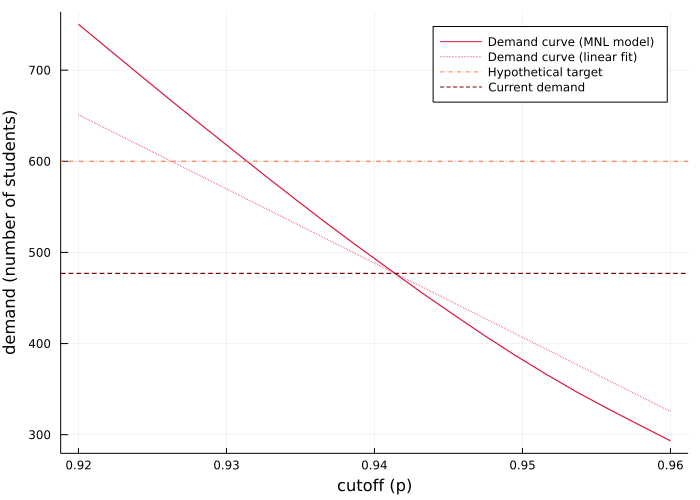

In [102]:
b, m = [1    usadmit[single_out, base_year * "cutoff"]  ;
        1                       1                       ] \ [usadmit[single_out, base_year * "demand"], 0]

function plot_single(cuts, curves)
    pl = plot(xlabel="cutoff (p)", ylabel="demand (number of students)",
              size=(700, 500))
    
    colors = [:crimson, :dodgerblue, :olivedrab, :rebeccapurple]
    
    c = 1
    i = single_out
    
    plot!(pl,
          cuts, 
          curves[:, c],
          label="Demand curve (MNL model)",#invopt_results[i, :name],
          color = colors[c], lw=1.2)


    plot!(pl, [cuts[1], cuts[end]], b .+ m * [cuts[1], cuts[end]],
      ls=:dot, color = :crimson, label="Demand curve (linear fit)", lw=1.2)

    hline!(pl,
          [600],
           ls=:dashdot, c=:coral, label="Hypothetical target", lw=1.2)

    hline!(pl,
           [usadmit[i, base_year * "demand"]],
           color = :maroon, ls=:dash, label="Current demand", lw=1.2)

    return pl
end

single_plot = plot_single(single_out_curve...)

In [69]:
1 - (600/471)*(1 - usadmit[50, "2015cutoff"])

0.9253353236458315

In [92]:
# Target cutoff predicted by my model; manually inspect curve to see idx
b2, m2 = [[1, 1] single_out_curve[1][6:7]] \ single_out_curve[2][6:7]
(600 - b2) / m2

0.9313875206518039

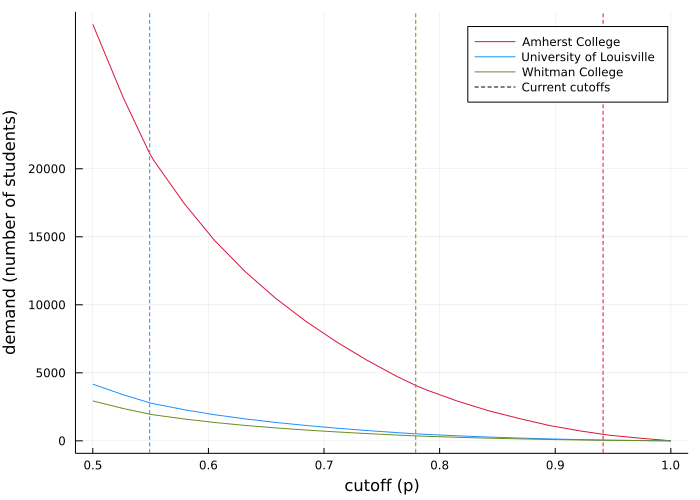

In [103]:
allthree = calc_demand_curves(range(0.5, 1, length=20), idxs_to_plot)
allthree_plot = plot_demand_curves(allthree...)

In [106]:
# savefig(single_plot, "paper/singlescoreplots/single-demand-curve.pdf")

# savefig(allthree_plot, "paper/singlescoreplots/three-demand-curves.pdf")